### Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import nltk
from sklearn.preprocessing import StandardScaler

Load Data

In [2]:
df = pd.read_csv("Car_Reviews_Database.csv", delimiter=";", index_col=0, encoding='latin1')

In [3]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [4]:
df.head()

,Model,Review
Year,,
2009,Honda,Although arguably the first-generation Insight...
2009,Honda,2009 Honda Accord EX-L 4 : This car is very c...
2010,Honda,I have owed and driven Honda products for 20 y...
2010,Honda,Honda Accord Euro L : The seats are average bu...
2011,Honda,Honda HR-V: Continuous variable transmission ...


In [5]:
df.describe

<bound method NDFrame.describe of                                                    Model   \
Year                                                        
2009                                                Honda   
2009                                                Honda   
2010                                                Honda   
2010                                                Honda   
2011                                                Honda   
...                                                   ...   
NaN                                                   NaN   
NaN                                                   NaN   
NaN                                                   NaN   
NaN                                                   NaN   
;;; it's by far one of the most reliable cars I...    NaN   

                                                                                               Review  
Year                                                                

Jumlah nilai yang null

In [6]:
total = df.isnull().sum().sort_values(ascending=False)

percent = (df.isnull().sum()/df.isnull().count())\
.sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, \
                        keys=['Total', 'Missing Percent'])

missing_data['Missing Percent'] = \
missing_data['Missing Percent'].apply(lambda x: x * 100)

missing_data.loc[missing_data['Missing Percent'] > 10][:10]

,Total,Missing Percent
Review,193,47.772277
Model,192,47.524752


In [7]:
df.isnull().sum()

Model     192
Review    193
dtype: int64

### Data Cleaning

In [8]:
dc = pd.read_csv("Car_Reviews_Database.csv", delimiter=";", index_col=0, encoding='latin1')
dc = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [9]:
print(dc.shape)

(404, 2)


Drop Missing Value

In [10]:
dc = dc.dropna()
print(dc.shape)

(211, 2)


In [11]:
total = dc.isnull().sum().sort_values(ascending=False)

percent = (dc.isnull().sum()/dc.isnull().count())\
.sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, \
                        keys=['Total', 'Missing Percent'])

missing_data['Missing Percent'] = \
missing_data['Missing Percent'].apply(lambda x: x * 100)

missing_data.loc[missing_data['Missing Percent'] > 10][:10]

,Total,Missing Percent


In [12]:
dc.isnull().sum()

Model     0
Review    0
dtype: int64

In [13]:
dc.head(10)

,Model,Review
Year,,
2009,Honda,Although arguably the first-generation Insight...
2009,Honda,2009 Honda Accord EX-L 4 : This car is very c...
2010,Honda,I have owed and driven Honda products for 20 y...
2010,Honda,Honda Accord Euro L : The seats are average bu...
2011,Honda,Honda HR-V: Continuous variable transmission ...
2011,Honda,Not much has changed with the historically sec...
2012,Honda,Honda Ballade 150 1.5: This is the most reliab...
2012,Honda,Ride quality is top-notch though communication...
2013,Honda,Honda Jazz Hybrid 1.4 : This is my second Hond...


## Modelling

In [14]:
data_train = dc
data_test = dc

In [15]:
data_train.head()

,Model,Review
Year,,
2009,Honda,Although arguably the first-generation Insight...
2009,Honda,2009 Honda Accord EX-L 4 : This car is very c...
2010,Honda,I have owed and driven Honda products for 20 y...
2010,Honda,Honda Accord Euro L : The seats are average bu...
2011,Honda,Honda HR-V: Continuous variable transmission ...


In [16]:
data_test.head()

,Model,Review
Year,,
2009,Honda,Although arguably the first-generation Insight...
2009,Honda,2009 Honda Accord EX-L 4 : This car is very c...
2010,Honda,I have owed and driven Honda products for 20 y...
2010,Honda,Honda Accord Euro L : The seats are average bu...
2011,Honda,Honda HR-V: Continuous variable transmission ...


In [17]:
data_train['Text_Review'] = data_train['Review']

In [18]:
# Case Folding
data_train['Review'] = data_train['Review'].str.lower()
data_train.head()

,Model,Review,Text_Review
Year,,,
2009,Honda,although arguably the first-generation insight...,Although arguably the first-generation Insight...
2009,Honda,2009 honda accord ex-l 4 : this car is very c...,2009 Honda Accord EX-L 4 : This car is very c...
2010,Honda,i have owed and driven honda products for 20 y...,I have owed and driven Honda products for 20 y...
2010,Honda,honda accord euro l : the seats are average bu...,Honda Accord Euro L : The seats are average bu...
2011,Honda,honda hr-v: continuous variable transmission ...,Honda HR-V: Continuous variable transmission ...


In [19]:
# Tokenization Train
from nltk.tokenize import RegexpTokenizer
train_token = RegexpTokenizer(data_train['Review'])
train_token

RegexpTokenizer(pattern=Year
2009    although arguably the first-generation insight...
2009    2009 honda accord ex-l 4  : this car is very c...
2010    i have owed and driven honda products for 20 y...
2010    honda accord euro l : the seats are average bu...
2011     honda hr-v: continuous variable transmission ...
                              ...                        
2019    honda civic ex: very clever design and very sp...
2019    hyundai sonata 2.4: large car and spacious car...
2019    if you can deal with (or prefer?) rear-wheel d...
2019     ford escape xlt 2.5 : i really didn't want to...
2019    the bmw 3 series is known as a driver's car an...
Name: Review, Length: 211, dtype: object, gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)

In [20]:
import re, string
from nltk.tokenize import word_tokenize

def preprocessText(text, remove_stops=False):
    
    # Remove Everything Between Hard Brackets
    text = re.sub(pattern="\[.+?\]( )?", repl='', string=text)

    # Change "word+'" to "word+ng"
    text = re.sub(pattern="n\\\' ", repl='ng ', string=text)

    # Remove x4 and (x4)
    text = re.sub(pattern="(\()?x\d+(\))?", repl=' ', string=text)

    # Fix Apostrophe Issues
    text= re.sub(pattern="\\x91", repl="'", string=text)
    text = re.sub(pattern="\\x92", repl="'", string=text)
    text= re.sub(pattern="<u\+0092>", repl="'", string=text)
        
    # Special Cases
    text = re.sub(pattern="'til", repl="til", string=text)
    text = re.sub(pattern="'til", repl="til", string=text)
    text = re.sub(pattern="gon'", repl="gon", string=text)

    # Remove \n from Beginning
    text = re.sub(pattern='^\n', repl='', string=text)
    
    # Remove Double Spaces and Beginning with Whitespace
    text = re.sub(pattern='( ){2,}', repl=' ', string=text)
    text = text.strip()

    # Strip , ! ?, : and Remaining \n from Review
    text = ''.join([char.strip(",!?:") for char in text])
    text = text.replace('\n', ' ')
  

    #---------------------- Text Expansion ---------------------------------
    
    # specific
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"won\’t", "will not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"can\’t", "can not", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"let\’s", "let us", text)
    text = re.sub(r"ain't", "aint", text)
    text = re.sub(r"ain\’t", "aint", text)
    text = re.sub(r"wanna", "want to", text)
    text = re.sub(r"gonna", "going to", text)
    text = re.sub(r"gotta", "go to", text)
    
    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"n\’t", " not", text)
    text = re.sub(r"\’re", " are", text)
    text = re.sub(r"\’s", " is", text)
    text = re.sub(r"\’d", " would", text)
    text = re.sub(r"\’ll", " will", text)
    text = re.sub(r"\’t", " not", text)
    text = re.sub(r"\’ve", " have", text)
    text = re.sub(r"\’m", " am", text)
    text = re.sub(r"\â", "a", text)
    text = re.sub(r"sunshineas", "sunshine as", text)
    
    # Remove Symbols
    text = re.sub(r"[^\w\s]","", text)
    
    # Remove Single Char
    text = re.sub(r"\b[a-zA-Z]\b","", text)
   
    #Remove Number
    text = re.sub(r"\d+", "", text)
    
    #Remove Duplicate Char
    text = re.sub(r"o+h", "oh", text)
    text = re.sub(r"oh+", "", text)
    
    # Remove Remaining Punctuation
    punc = string.punctuation
    text = ''.join([char for char in text if char not in punc])

    # Remove Stopwords
    if remove_stops:
        stops = stopwords.words('english')
        data_train['Review'] = ' '.join([word for word in data_train['Review'].split(' ') if word not in stops])
    return(text)

data_train['Review'] = data_train['Review'].apply(preprocessText)

# NLTK word tokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)

data_train['Review'] = data_train['Review'].apply(word_tokenize_wrapper)

print('Tokenizing Result : \n') 
print(data_train['Review'])
print('\n\n\n')


Tokenizing Result : 

Year
2009    [although, arguably, the, firstgeneration, ins...
2009    [honda, accord, exl, this, car, is, very, comf...
2010    [have, owed, and, driven, honda, products, for...
2010    [honda, accord, euro, the, seats, are, average...
2011    [honda, hrv, continuous, variable, transmissio...
                              ...                        
2019    [honda, civic, ex, very, clever, design, and, ...
2019    [hyundai, sonata, large, car, and, spacious, c...
2019    [if, you, can, deal, with, or, prefer, rearwhe...
2019    [ford, escape, xlt, really, did, not, want, to...
2019    [the, bmw, series, is, known, as, driver, is, ...
Name: Review, Length: 211, dtype: object






In [21]:
# Stopwords Removal
from nltk.corpus import stopwords

stop = stopwords.words('english')
data_train['Review'] = data_train['Review'].apply(lambda x: [item for item in x if item not in stop])
data_train.head()

,Model,Review,Text_Review
Year,,,
2009,Honda,"[although, arguably, firstgeneration, insight,...",Although arguably the first-generation Insight...
2009,Honda,"[honda, accord, exl, car, comfortable, sporty,...",2009 Honda Accord EX-L 4 : This car is very c...
2010,Honda,"[owed, driven, honda, products, years, purchas...",I have owed and driven Honda products for 20 y...
2010,Honda,"[honda, accord, euro, seats, average, little, ...",Honda Accord Euro L : The seats are average bu...
2011,Honda,"[honda, hrv, continuous, variable, transmissio...",Honda HR-V: Continuous variable transmission ...


In [22]:
# Stemming
from nltk.stem.porter import PorterStemmer

stemming = PorterStemmer()
data_train['Review'] = data_train['Review'].apply(lambda x: [stemming.stem(y) for y in x])
data_train.head()

,Model,Review,Text_Review
Year,,,
2009,Honda,"[although, arguabl, firstgener, insight, hybri...",Although arguably the first-generation Insight...
2009,Honda,"[honda, accord, exl, car, comfort, sporti, cyl...",2009 Honda Accord EX-L 4 : This car is very c...
2010,Honda,"[owe, driven, honda, product, year, purchas, v...",I have owed and driven Honda products for 20 y...
2010,Honda,"[honda, accord, euro, seat, averag, littl, rea...",Honda Accord Euro L : The seats are average bu...
2011,Honda,"[honda, hrv, continu, variabl, transmiss, fail...",Honda HR-V: Continuous variable transmission ...


In [23]:
# Lemmatization
from nltk.stem import WordNetLemmatizer

lemmatization = WordNetLemmatizer()
data_train['Review'] = data_train['Review'].apply(lambda x: [lemmatization.lemmatize(y) for y in x])
data_train.head()

,Model,Review,Text_Review
Year,,,
2009,Honda,"[although, arguabl, firstgener, insight, hybri...",Although arguably the first-generation Insight...
2009,Honda,"[honda, accord, exl, car, comfort, sporti, cyl...",2009 Honda Accord EX-L 4 : This car is very c...
2010,Honda,"[owe, driven, honda, product, year, purchas, v...",I have owed and driven Honda products for 20 y...
2010,Honda,"[honda, accord, euro, seat, averag, littl, rea...",Honda Accord Euro L : The seats are average bu...
2011,Honda,"[honda, hrv, continu, variabl, transmiss, fail...",Honda HR-V: Continuous variable transmission ...


In [47]:
# Feature Selection (N-Grams)
from nltk.util import ngrams

# Unigrams
for words in data_train['Review']:
    unigrams = ngrams(words, 1)
    for i, gram_rev in enumerate(unigrams):
        print(gram_rev)

('although',)
('arguabl',)
('firstgener',)
('insight',)
('hybrid',)
('powertrain',)
('uniqu',)
('style',)
('made',)
('ahead',)
('time',)
('rebirth',)
('insight',)
('secondgener',)
('model',)
('design',)
('much',)
('greater',)
('global',)
('appeal',)
('honda',)
('accord',)
('exl',)
('car',)
('comfort',)
('sporti',)
('cylind',)
('best',)
('transmiss',)
('car',)
('year',)
('car',)
('owe',)
('driven',)
('honda',)
('product',)
('year',)
('purchas',)
('vehicl',)
('march',)
('true',)
('honda',)
('fanat',)
('end',)
('piec',)
('junk',)
('never',)
('busi',)
('honda',)
('automobil',)
('product',)
('seat',)
('extrem',)
('uncomfort',)
('becom',)
('appar',)
('minut',)
('worst',)
('thing',)
('headrest',)
('lean',)
('far',)
('forward',)
('head',)
('bent',)
('shoulder',)
('forc',)
('seat',)
('tri',)
('drive',)
('like',)
('minut',)
('time',)
('forc',)
('either',)
('remov',)
('headrest',)
('park',)
('car',)
('dealer',)
('american',)
('honda',)
('useless',)
('attempt',)
('find',)
('way',)
('correct',)
('s

In [48]:
# Bigrams
for words in data_train['Review']:
    bigrams = ngrams(words, 2)
    for i, gram_rev in enumerate(bigrams):
        print(gram_rev)

('although', 'arguabl')
('arguabl', 'firstgener')
('firstgener', 'insight')
('insight', 'hybrid')
('hybrid', 'powertrain')
('powertrain', 'uniqu')
('uniqu', 'style')
('style', 'made')
('made', 'ahead')
('ahead', 'time')
('time', 'rebirth')
('rebirth', 'insight')
('insight', 'secondgener')
('secondgener', 'model')
('model', 'design')
('design', 'much')
('much', 'greater')
('greater', 'global')
('global', 'appeal')
('honda', 'accord')
('accord', 'exl')
('exl', 'car')
('car', 'comfort')
('comfort', 'sporti')
('sporti', 'cylind')
('cylind', 'best')
('best', 'transmiss')
('transmiss', 'car')
('car', 'year')
('year', 'car')
('owe', 'driven')
('driven', 'honda')
('honda', 'product')
('product', 'year')
('year', 'purchas')
('purchas', 'vehicl')
('vehicl', 'march')
('march', 'true')
('true', 'honda')
('honda', 'fanat')
('fanat', 'end')
('end', 'piec')
('piec', 'junk')
('junk', 'never')
('never', 'busi')
('busi', 'honda')
('honda', 'automobil')
('automobil', 'product')
('product', 'seat')
('seat

In [49]:
# Trigrams
for words in data_train['Review']:
    trigrams = ngrams(words, 3)
    for i, gram_rev in enumerate(trigrams):
        print(gram_rev)

('although', 'arguabl', 'firstgener')
('arguabl', 'firstgener', 'insight')
('firstgener', 'insight', 'hybrid')
('insight', 'hybrid', 'powertrain')
('hybrid', 'powertrain', 'uniqu')
('powertrain', 'uniqu', 'style')
('uniqu', 'style', 'made')
('style', 'made', 'ahead')
('made', 'ahead', 'time')
('ahead', 'time', 'rebirth')
('time', 'rebirth', 'insight')
('rebirth', 'insight', 'secondgener')
('insight', 'secondgener', 'model')
('secondgener', 'model', 'design')
('model', 'design', 'much')
('design', 'much', 'greater')
('much', 'greater', 'global')
('greater', 'global', 'appeal')
('honda', 'accord', 'exl')
('accord', 'exl', 'car')
('exl', 'car', 'comfort')
('car', 'comfort', 'sporti')
('comfort', 'sporti', 'cylind')
('sporti', 'cylind', 'best')
('cylind', 'best', 'transmiss')
('best', 'transmiss', 'car')
('transmiss', 'car', 'year')
('car', 'year', 'car')
('owe', 'driven', 'honda')
('driven', 'honda', 'product')
('honda', 'product', 'year')
('product', 'year', 'purchas')
('year', 'purchas'

In [24]:
from textblob import TextBlob

def senti(x):
    return TextBlob(x).sentiment  

data_train['Sentiment'] = data_train['Review'].apply(lambda x: senti(' '.join(x)))

In [25]:
data_train['Sentiment']

Year
2009                                  (0.25, 0.25)
2009                                    (1.0, 0.3)
2010    (-0.15833333333333335, 0.5416666666666666)
2010                                    (0.5, 1.0)
2011                   (-0.5, 0.29999999999999993)
                           ...                    
2019      (0.3952380952380952, 0.5869047619047619)
2019     (0.1638888888888889, 0.48888888888888893)
2019      (0.2333333333333333, 0.7000000000000001)
2019                                    (0.0, 0.0)
2019    (-0.30333333333333334, 0.5933333333333334)
Name: Sentiment, Length: 211, dtype: object

In [26]:
data_train[['Polarity','Subjectivity']] = pd.DataFrame(data_train['Sentiment'].tolist(), index= data_train.index)

In [27]:
data_train.head()

,Model,Review,Text_Review,Sentiment,Polarity,Subjectivity
Year,,,,,,
2009,Honda,"[although, arguabl, firstgener, insight, hybri...",Although arguably the first-generation Insight...,"(0.25, 0.25)",0.250000,0.250000
2009,Honda,"[honda, accord, exl, car, comfort, sporti, cyl...",2009 Honda Accord EX-L 4 : This car is very c...,"(1.0, 0.3)",1.000000,0.300000
2010,Honda,"[owe, driven, honda, product, year, purchas, v...",I have owed and driven Honda products for 20 y...,"(-0.15833333333333335, 0.5416666666666666)",-0.158333,0.541667
2010,Honda,"[honda, accord, euro, seat, averag, littl, rea...",Honda Accord Euro L : The seats are average bu...,"(0.5, 1.0)",0.500000,1.000000
2011,Honda,"[honda, hrv, continu, variabl, transmiss, fail...",Honda HR-V: Continuous variable transmission ...,"(-0.5, 0.29999999999999993)",-0.500000,0.300000


In [28]:
# negative, nautral, positive analysis
def getTextAnalysis(a):
    if a < 0:
        return "Negative"
    elif a == 0:
        return "Neutral"
    else:
        return "Positive"

data_train['Score'] = data_train['Polarity'].apply(getTextAnalysis)

In [29]:
data_train.head()

,Model,Review,Text_Review,Sentiment,Polarity,Subjectivity,Score
Year,,,,,,,
2009,Honda,"[although, arguabl, firstgener, insight, hybri...",Although arguably the first-generation Insight...,"(0.25, 0.25)",0.250000,0.250000,Positive
2009,Honda,"[honda, accord, exl, car, comfort, sporti, cyl...",2009 Honda Accord EX-L 4 : This car is very c...,"(1.0, 0.3)",1.000000,0.300000,Positive
2010,Honda,"[owe, driven, honda, product, year, purchas, v...",I have owed and driven Honda products for 20 y...,"(-0.15833333333333335, 0.5416666666666666)",-0.158333,0.541667,Negative
2010,Honda,"[honda, accord, euro, seat, averag, littl, rea...",Honda Accord Euro L : The seats are average bu...,"(0.5, 1.0)",0.500000,1.000000,Positive
2011,Honda,"[honda, hrv, continu, variabl, transmiss, fail...",Honda HR-V: Continuous variable transmission ...,"(-0.5, 0.29999999999999993)",-0.500000,0.300000,Negative


In [30]:
positive = data_train[data_train['Score'] == 'Positive']

print("Positive Reviews : " + str(positive.shape[0]/(data_train.shape[0])*100) + " %")

Positive Reviews : 72.98578199052133 %


<BarContainer object of 3 artists>

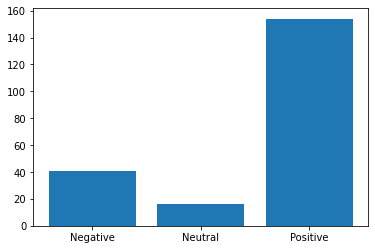

In [31]:
labels = data_train.groupby('Score').count().index.values
values = data_train.groupby('Score').size().values

plt.bar(labels, values)

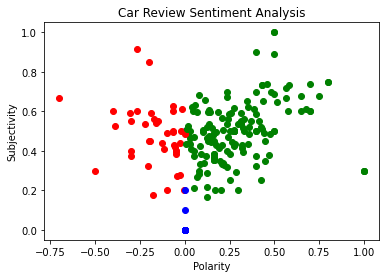

In [32]:
for index, row in data_train.iterrows():
    if row['Score'] == 'Positive':
        plt.scatter(row['Polarity'], row['Subjectivity'], color="green")
    elif row['Score'] == 'Negative':
        plt.scatter(row['Polarity'], row['Subjectivity'], color="red")
    elif row['Score'] == 'Neutral':
        plt.scatter(row['Polarity'], row['Subjectivity'], color="blue")

plt.title('Car Review Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
# add legend
plt.show()

In [33]:
objective = data_train[data_train['Subjectivity'] == 0]

print("Objective Tweets : " + str(objective.shape[0]/(data_train.shape[0])*100) + " %")

Objective Tweets : 6.161137440758294 %


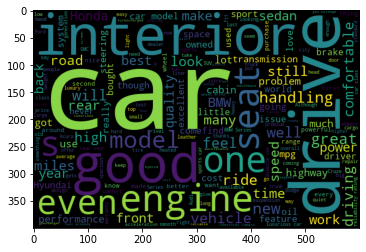

In [34]:
# Creating a Word Cloud
from wordcloud import WordCloud

words = ' '.join([review for review in data_train['Text_Review']])
wordCloud = WordCloud(width=600, height=400).generate(words)

plt.imshow(wordCloud)
plt.show()

In [61]:
# SVM dengan TF-IDF
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def do(tokens):
    return tokens

count_vect = CountVectorizer(tokenizer=do, lowercase=False)
X_train_tf = count_vect.fit_transform(data_train['Review'])
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf)
model_svm_tfidf = OneVsRestClassifier(svm.SVC(gamma=0.02, C=100., probability=True, class_weight='balanced', kernel='linear'))
model_svm_tfidf.fit(X_train_tfidf, data_train['Score'])

OneVsRestClassifier(estimator=SVC(C=100.0, class_weight='balanced', gamma=0.02,
                                  kernel='linear', probability=True))

In [64]:
# Evaluasi SVM dengan TF IDF

from sklearn.metrics import classification_report

X_test_tf = count_vect.transform(data_train['Review'])
X_test_tfidf = tfidf_transformer.transform(X_test_tf)

predicted = model_svm_tfidf.predict(X_test_tfidf)

y_true = data_train['Score']
y_pred = predicted

target_names = data_train['Score'].unique()
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=1))

              precision    recall  f1-score   support

    Positive       1.00      1.00      1.00        41
    Negative       1.00      1.00      1.00        16
     Neutral       1.00      1.00      1.00       154

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



In [67]:
# Evaluasi SVM dengan K-Fold Cross Validation

from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

category_svm = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,2))),
                     ('svm', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4,
                                            random_state=123))])

category_svm = category_svm.fit(data_train['Text_Review'], data_train['Score'])
cross_val_score(estimator=category_svm, X=data_train['Text_Review'], y=data_train['Score'], cv=7).mean()


# Melakukan evaluasi terhadap model SVM yang telah dibangun dengan K-Fold Cross Validation

print(category_svm.score(y=data_train['Score'], X=data_train['Text_Review']))
preds_svm = category_svm.predict(data_train['Text_Review'])
print(classification_report(y_pred=preds_svm, y_true=data_train['Score']))
pd.crosstab(preds_svm, data_train['Score'])

1.0
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        41
     Neutral       1.00      1.00      1.00        16
    Positive       1.00      1.00      1.00       154

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



Score,Negative,Neutral,Positive
row_0,,,
Negative,41,0,0
Neutral,0,16,0
Positive,0,0,154
